<a href="https://colab.research.google.com/github/ScottVinay/Deep-abstractive-summariser/blob/master/keras_nlp_summariser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notes

To do

- Evaluation metric to set the damping hyperparameter

- Length Bayes correction

- Multi-decoder network - decoding both the headline and the main title

- RE unknown tokens. A script to consider _u_ in the output, and replace it with a _u_ from the input. 

Problems I have faced and overcome

- Whole thing won't fit into memory - tried turning into batches, turned out to be the model is too big. Reduce embedding params

- Unknown tokens seem to be too prevalent, and become highly represented in the output.

- Sentences finish too quickly, high bias towards end token. Solution, manually dampen the __end__token term. TODO - find a way to set this as a hyperparameter.

- Coded in beam searching.

# Preliminaries

## Google Drive

In [1]:
path = '/content/drive/My Drive/Python scripts/Data Science/Summariser/'

In [2]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Modules and global functions

In [3]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#from nltk.corpus import stopwords # Need this?
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import random
import math
import time

import re
import pickle

import sys

In [4]:
def progressBar(n, tot):
    perc = int(100*n/tot)
    milli = round(100*n/tot,1)
    print('\r{}/{} ({}%) [{}{}]'.format(n,tot,milli,u'\u25A4'*perc, '_'*(100-perc)),end='')

# Dataframe manipulation

## Loading the dataframe

In [6]:
load = 1

In [7]:
#%% Load
if load==0:
    df = pd.read_csv(path+'wikihowSep.csv')

    df.drop(columns=['overview','sectionLabel'],inplace=True)

    titles_to_drop = [
    'How to Be Well Read', # This is full of loads of specific titles
    ]

    for title in titles_to_drop:
        df = df[df['title']!=title]
        df.reset_index(drop=True, inplace=True)

    df = df.dropna().reset_index(drop=True)
    df['cleaned'] = 0
    start_index = 0

if load==1:
    df = pd.read_pickle(path+'df_split_transformed_June_01.pkl')
    start_index = df['cleaned'].sum()

## Cleaning the dataframe

In [7]:
#%% Functions

def replaceAbbr(text):
    #XX need spaces before and after every word when we do this
    abbrs = [
    ["don't","do not"], ["can't", "can not"], ["won't", "will not"], ["shan't", "shall not"],
    ["dont","do not"], ["cant", "can not"], ["wont", "will not"], ["shant", "shall not"],
     
    ["i'll", "i will"], ["you'll", "you will"], ["youll", "you will"],
    ["we'll", "we will"], ["he'll", "he will"], ["she'll", "she will"],
     
    ["i'm", "i am"], ["im", "i am"], ["you're", "you are"], ["youre", "you are"],
    ["we're", "we are"],
     
    ["i've", "i have"], ["ive", "i have"], ["you've", "you have"], ["youve", "you have"],
    ["we've", "we have"]
    ]

    for ab, full in abbrs:
        text = re.sub("( {} )".format(ab), " {} ".format(full), text)
    return text

def cleanText(text):
    # Include \n\n = paragraph?
    # Include small and large numbers?
    if '__start__' in text or '__end__' in text: return text
    text = replaceAbbr(text)
    text = re.sub(r'(\.\s)', ' __fs__ ', text)
    text = re.sub(r'[,]', ' __cm__ ', text)
    text = re.sub(r'[/]', ' or ', text)
    text = re.sub(r'[\n-]', ' ', text)
    text = re.sub(r'[^a-zA-Z\d_\s]', '', text)
    text = text.lower()
    text = text.strip(' ')
    text = '__start__ ' + text + ' __end__'
    return text

In [34]:
start_index

287501

In [13]:
#%% Clean

cleanLimit = len(df)
start_index = df['cleaned'].sum()
st = time.time()
for irow in range(start_index, cleanLimit):
    df.loc[irow, 'text']     = cleanText(df.loc[irow, 'text'])
    df.loc[irow, 'headline'] = cleanText(df.loc[irow, 'headline'])
    df.loc[irow, 'title']    = cleanText(df.loc[irow, 'title'])
    df.loc[irow, 'cleaned'] = 1
    if irow%10==0:
        progressBar(irow,cleanLimit)
    if irow%500==0:
        df.to_pickle(path+'df_split_transformed_June_01.pkl')
progressBar(cleanLimit,cleanLimit)
print('Done')
df.to_pickle(path+'df_split_transformed_June_01_complete.pkl')
print('Time = ',time.time()-st)

287880/1387270 (20.8%) [▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤________________________________________________________________________________]

KeyboardInterrupt: ignored

# Dataset creation

## Find text and headline lengths

In [ ]:
#%% Examine lengths

df = df[:start_index-1] # Just train on cleaned samples

textlens = []
headlens = []

for irow in range(len(df)):
    if irow%1000==0: progressBar(irow+1, len(df))
    textlens.append(len(df.loc[irow,'text'].split()))
    headlens.append(len(df.loc[irow,'headline'].split()))
progressBar(len(df), len(df))

1387270/1387270 (100.0%) [▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤▤]

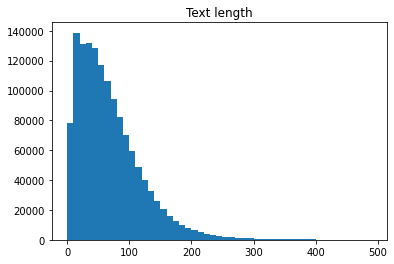

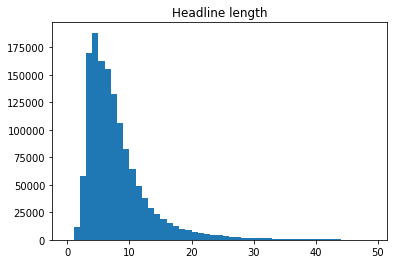

In [ ]:
plt.hist(textlens, bins=np.arange(0,500,10)); plt.title('Text length'); plt.show();
plt.hist(headlens, bins=np.arange(0,50,1)); plt.title('Headline length'); plt.show();

## Train/test split

In [8]:
# From the above histograms, we determine:
max_text_len = 300
max_head_len = 30

In [9]:
#%%

from sklearn.model_selection import train_test_split

(xtr,
 xcv,
 ytr,
 ycv) = train_test_split(
         df['text'],
         df['headline'],
         test_size=0.05,
         random_state=0,
         shuffle=True)

#%%

## Tokenisation

In [10]:
df = df[:start_index-1] # in case the earler cell was skipped

# Without setting a max num_words, there are many words in the vocabulary. 
# This results in massive embedding layers (since they need to map from R2500
# to something smaller.)
tokenizer = Tokenizer(
    num_words=2000,
    oov_token = None)#'__unknown__')

# We want to set it so that the tokenizer does NOT remove _
index__ = tokenizer.filters.index('_')
new_filter = tokenizer.filters[:index__] + tokenizer.filters[index__ + 1:]
tokenizer.filters = new_filter

tokenizer.fit_on_texts(list(xtr) + list(ytr))

In [11]:
xtr_tok = tokenizer.texts_to_sequences(xtr)
xcv_tok = tokenizer.texts_to_sequences(xcv)

ytr_tok = tokenizer.texts_to_sequences(ytr)
ycv_tok = tokenizer.texts_to_sequences(ycv)

xtr_tok = pad_sequences(xtr_tok, maxlen=max_text_len, padding='post')
xcv_tok = pad_sequences(xcv_tok, maxlen=max_text_len, padding='post')

# Convert list of arrays into 2D array
xtr_tok = np.stack(xtr_tok)
xcv_tok = np.stack(xcv_tok)

ytr_tok = pad_sequences(ytr_tok, maxlen=max_head_len, padding='post')
ycv_tok = pad_sequences(ycv_tok, maxlen=max_head_len, padding='post')

#TODO Do we need to stack yxx_tok too?

vocab_size = len(tokenizer.word_index)+1

# Here I've changed it. Above is what is given in the tutorial, below is
# the new one. word_index is hundreds of thousands. It is the pure index
# of each word. However, these are cut-off at num_words. The +1 is for 
# the special token for unknown words
vocab_size = tokenizer.num_words + 1

end_tok = tokenizer.texts_to_sequences(['__end__'])[0][0]

def set_last_to_end(tok_list, end_tok):
    for i in range(len(tok_list)):
        if tok_list[i][-1] not in [0, end_tok]:
            tok_list[i][-1] = end_tok
    return tok_list

xtr_tok = set_last_to_end(xtr_tok,end_tok)
ytr_tok = set_last_to_end(ytr_tok,end_tok)

getword  = tokenizer.index_word
getindex = tokenizer.word_index

## Creating objects for model

In [12]:
def get_model_data(xtok,ytok):
    a = [ xtok, ytok[:,:-1] ] # For enc_in, dec_in
    b = ytok.reshape(ytok.shape[0], ytok.shape[1], 1)[:,1:]
    return a, b

In [13]:
xtr_tok_modin, ytr_tok_modin = get_model_data(
            xtr_tok,
            ytr_tok
            )
        
xcv_tok_modin, ycv_tok_modin = get_model_data(
            xcv_tok,
            ycv_tok
            )

# Modeling

## Model creation

In [14]:
#%% Create the model

# Prefix L_ = layer instance
# Prefix I_ = special input layer instance

latent_dim_1 = 200
latent_dim_2 = 200

### Encoding layers

I_enc_in = Input(name='Encoder_input',shape=(max_text_len,))

L_enc_embed = Embedding(
        name='Encoder_embedding',
        input_dim = vocab_size,
        output_dim = latent_dim_1,
        trainable = True,
        input_length = max_text_len,
        ) #TODO include masking?

L_enc_lstm = LSTM(
    latent_dim_2,
    return_sequences=False, #TODO true for Attention
    return_state=True,
    name='Encoder_LSTM'
    )

### Encoding connections

enc_embedded = L_enc_embed(I_enc_in)
enc_out, state_h, state_c = L_enc_lstm(enc_embedded)
# If return_sequences = True, then enc_out = state_h?

### Decoding layers

#I_dec_in = Input(shape = (max_head_len - 1,))
I_dec_in = Input(name='dec_ins',shape = (None,))

L_dec_embed = Embedding(
    vocab_size,
    latent_dim_1,
    input_length = max_head_len - 1 ,
    trainable=True,
    name='Dec_embedding'
    )

L_dec_lstm = LSTM(
                  latent_dim_2,
                  return_sequences=True,
                  return_state=True,
                  name='Dec_lstm',
                  )

#TODO TimeDistributed = Necessary? Learn about this!
L_dec_dense = TimeDistributed(
                              Dense(vocab_size, activation = 'softmax'),
                              name='Time_Dist',
                              )

### Decoding connections

dec_embedded = L_dec_embed(I_dec_in)

dec_lstm_out, _, _  = L_dec_lstm(
                                dec_embedded,
                                initial_state=[state_h, state_c],
                                )

dec_out = L_dec_dense(dec_lstm_out)

###

model = Model([I_enc_in, I_dec_in], dec_out)
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
# Sparse is not written in tuts, but seems to be required

In [15]:
# Checkpoints 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

savepath = path + 'weights_03_smalltok.hdf5'
checkpoint = ModelCheckpoint(savepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

## Load model

In [16]:
model.load_weights(path+'weights_03_smalltok.hdf5')

## Fit model

In [16]:
history = model.fit(
                xtr_tok_modin,
                ytr_tok_modin,

                epochs = 12,
                callbacks = [es,checkpoint],
                batch_size = 64,
                validation_data = (xcv_tok_modin, ycv_tok_modin),
                )

Epoch 1/12
20593/20593 [==============================] - ETA: 0s - loss: 0.8329 - acc: 0.8497
Epoch 00001: loss improved from inf to 0.83294, saving model to /content/drive/My Drive/Python scripts/Data Science/Summariser/weights_03_smalltok.hdf5
20593/20593 [==============================] - 905s 44ms/step - loss: 0.8329 - acc: 0.8497 - val_loss: 0.7497 - val_acc: 0.8560
Epoch 2/12
20592/20593 [============================>.] - ETA: 0s - loss: 0.7299 - acc: 0.8575
Epoch 00002: loss improved from 0.83294 to 0.72987, saving model to /content/drive/My Drive/Python scripts/Data Science/Summariser/weights_03_smalltok.hdf5
20593/20593 [==============================] - 898s 44ms/step - loss: 0.7299 - acc: 0.8575 - val_loss: 0.7165 - val_acc: 0.8592
Epoch 3/12
20592/20593 [============================>.] - ETA: 0s - loss: 0.7040 - acc: 0.8601
Epoch 00003: loss improved from 0.72987 to 0.70397, saving model to /content/drive/My Drive/Python scripts/Data Science/Summariser/weights_03_smalltok.

KeyboardInterrupt: ignored

# Translation

## Create separate translation models

In [17]:
#%% Now we make separate encoder and decoder models

encoder_model = Model(
        inputs = I_enc_in,
        outputs = [enc_out, state_h, state_c]
        )

I_decoder_h = Input(shape=(latent_dim_2,))
I_decoder_c = Input(shape=(latent_dim_2,))
I_decoder_m = Input(shape=(max_text_len,latent_dim_1))

dec_embedded_2 = L_dec_embed(I_dec_in)

dec_lstm_out_2, dec_h_2, dec_c_2  = L_dec_lstm(
                                        dec_embedded_2,
                                        initial_state=[I_decoder_h, I_decoder_c],
                                        )

dec_out_2 = L_dec_dense(dec_lstm_out_2)

decoder_model = Model(
        [I_dec_in] + [I_decoder_h, I_decoder_c],
        # With attn: [I_dec_in] + [I_decoder_m, I_decoder_h, I_decoder_c],
        [dec_out_2] + [dec_h_2, dec_c_2]
        )

## Sampling functions

In [18]:
# Single path

def probSampler(tokens_in):
    tokens = tokens_in[1:] # to account for 0 padding
    chosen = np.random.choice(len(tokens), 1, p=tokens/sum(tokens))[0]
    chosen = chosen + 1 # to account for 0 padding
    return chosen

def suppressedArgmax(tokens, damping=2):
    chosen, _ = beamSuppressedArgmax(tokens, damping=damping, beamwidth=1)
    return chosen[0]

def basicArgmax(tokens):
    chosen, _ = beamSuppressedArgmax(tokens, damping=1, beamwidth=1)
    return chosen[0]

# Beam samplers

def beamSuppressedArgmax(tokens_in, damping=50, beamwidth=3):
    tokens = tokens_in[1:] # account for 0 padding
    tokens[getindex['__end__'] - 1] /= damping
    
    # The tokens of the words with the greatest conditional probabilities.
    chosenTokens = tokens.argsort()[::-1][:beamwidth]
    # The conditional probabilities themselves.
    chosenProbs = tokens[chosenTokens]
    chosenTokens += 1 # account for 0 padding
    return chosenTokens, chosenProbs

## Translation functions

### General

In [51]:
#%%

# Now to translate a sequence

def passThroughEncoder(input_text):
    split_in = input_text.split(' ')
    if split_in[0] != '__start__':
        split_in = ['__start__'] + split_in
    if split_in[-1] != '__end__':
        split_in = split_in + ['__end__']

    new_text = ' '.join(split_in)
    input_toks = tokenizer.texts_to_sequences([new_text])
    input_toks = pad_sequences(np.array(input_toks), max_text_len, padding='post')

    e_out, e_h, e_c = encoder_model.predict(input_toks) 
    return e_out, e_h, e_c

def neaten(text):
    text = text.replace(' __cm__', ',')
    text = text.replace(' __fs__', '.')
    text = text.replace('__start__ ', '')
    text = text.replace(' __end__', '')
    text = text.strip(' ')
    text = text.strip('\n')
    sents = text.split('. ')
    if len(text)>1:
        text = text[0].upper()+text[1:]
    text = '. '.join(i.capitalize() for i in sents)
    return text

### Greedy

In [ ]:
def translate(input_text, sampler=np.argmax, damping=1):
    e_out, e_h, e_c = passThroughEncoder(input_text)

    decoder_input = np.zeros((1,1))
    decoder_input[0,0] = getindex['__start__']

    output_sequence = []
    out_len = 0
    stopper = False
    while not stopper:

        output_tokens, h, c = decoder_model.predict(
                [decoder_input] + [e_h, e_c] 
                )

        # next_token is a number
        output_tokens = output_tokens[0,-1,:]
        next_token = sampler(output_tokens, damping=damping) 
        # TODO check if damping is a keyword of sampler

        output_sequence.append(getword[next_token])

        out_len += 1

        if getword[next_token] == '__end__' or out_len >= 2*max_head_len:
            break

        decoder_input[0, 0] = next_token
        e_h, e_c = h, c # why?

    return neaten(' '.join(output_sequence))

### Beam

In [59]:
def beamTranslate(
    input_text,
    width=3,
    finalWidth=3, # this might NEED to be equal to width, have a think
    damping=20,
    sampler=beamSuppressedArgmax,
    lengthBayes=False
    ):

    e_out, e_h, e_c = passThroughEncoder(input_text)

    decoder_input = np.zeros((1,1))
    decoder_input[0,0] = getindex['__start__']

    currentBeam = [{
        'outseq':['__start__',], # note, this is a list unlike the strong in the other func
        'len':0,
        'prob':1,
        'h':e_h,
        'c':e_c,
        }]*1 # start with 1

    finalSentences = []

    stopper = False
    while not stopper:

        newBeam = []

        for cand in currentBeam: # cand = candidate
            decoder_input[0,0] = getindex[cand['outseq'][-1]]
            # h, c change when a word is passed through the decoder,
            # so we need to store these for each possible candidate sentence.
            h = cand['h']
            c = cand['c']

            output_tokens, new_h, new_c = decoder_model.predict(
                    [decoder_input] + [h, c] 
                    )
            output_tokens = output_tokens[0,-1,:]

            next3tokens, next3condProbs = sampler(output_tokens, damping=damping)

            for token, conProb in zip(next3tokens, next3condProbs):
                word = getword[token]

                if word=='__end__':
                    finalSentences.append({
                        # ' '.join(...) creates a single sentence from 
                        # the list. We apply neaten to make it human-readable.
                        'sent': neaten(' '.join(cand['outseq'])),
                        'prob': cand['prob']*conProb,
                        'len': cand['len']+1,
                    })

                else:
                    new_outseq = cand['outseq'].copy()
                    new_outseq.append(word)

                    newBeam.append({
                        'outseq': new_outseq,
                        'len': cand['len']+1,
                        'prob': cand['prob']*conProb, # = joint prob ya?
                        'h': new_h,
                        'c': new_c
                    })
        
        if len(finalSentences)>=finalWidth:
            stopper = True
            break

        currentBeam = sorted(newBeam, key=lambda x: x['prob'])[::-1][:width]

    finalSentences = sorted(finalSentences, key = lambda x: x['prob'])[::-1][:width]
    return finalSentences

## Testing

### Greedy

In [20]:
i=np.random.randint(0,7850) # = len xcv

print(i)
print('\n')


print('Text:')
print(neaten(xcv.loc[xcv.index[i]]))
print('\n')

print('Actual headline:')
print(neaten(ycv.loc[xcv.index[i]]))
print('\n')

print('Generated headline:')
print( translate(xcv.loc[xcv.index[i]] , suppressedArgmax, damping=10) )

5685


Text:
This can make it even more twirly. You can use regular satin ribbon or curling ribbon (like the type you'd use on a balloon). Cut five to seven pieces of ribbon that are a little bit shorter than your dowel and glue them to the top of your dowel.




Actual headline:

consider adding some very thin ribbon strands to the top of your wand.


Generated headline:
Tie a ribbon around the top of the


### Beam

In [80]:
i=np.random.randint(0,7850) # = len xcv

print(i)
print('\n')


print('Text:')
print(neaten(xcv.loc[xcv.index[i]]))
print('\n')

print('Actual headline:')
print(neaten(ycv.loc[xcv.index[i]]))
print('\n')

print('Generated headlines:')

for io, output in enumerate(beamTranslate(xcv.loc[xcv.index[i]] , damping=20)):
    print('{}.'.format(io+1), output['sent'])

4037


Text:
You may find that they are supportive of your decision. If they are more traditional, you may encounter some resistance. Just keep in mind that you need not justify your decision to anyone. Hopefully, they will soon respect your plans to keep your full identity.


Actual headline:
Inform his parents, and yours.


Generated headlines:
1. Dont be afraid to ask for help
2. Dont be afraid to ask for advice
3. Dont be afraid to ask for help you


# Best outcomes

## Greedy outcomes

Text:
In addition to stiffness and spasms in the neck and jaw muscles,  tetanus also causes abdominal and spinal tightness or cramping,  widespread muscle twitching,  difficulty swallowing,  fever,  sweating and rapid heart rateif you have symptoms of tetanus,  you will need to be treated in a hospital  it is a serious infection that cannot be treated at home.   tetanus symptoms can appear anytime from a few days to several weeks after the bacteria enter your body  often through a puncture wound of the foot,  such as stepping on a contaminated nail. The doctor will rely on a physical exam,  as well as a medical and immunization history,  to diagnose tetanus. No lab or blood tests are helpful to detect tetanus. Diseases that cause similar symptoms to tetanus that your doctor will want to rule out include meningitis,  rabies and strychnine poisoningthe medical staff will need to clean the wound as well,  removing any debris,  dead tissue,  and foreign objects


Actual headline:
Go to the hospital


Generated headline:
See a doctor if the pain is severe and severe abdominal pain or swelling in the morning and take a year of pregnancy



Text:
Running water will not only clean the wound,  but help to stop the bleeding. Run cold water over the cut to constrict the blood vessels and stop the bleeding. Doing the same with hot water will cauterize the cut,  allowing the blood to clot. Dont use both hot and cold water   just one or the other should do the trick.   you can use an ice cube instead of cold water to close off the arteries. Hold the ice to the cut for a few seconds until the wound closes up and stops bleeding. If you have multiple small cuts on your body,  taking a hot shower will clean off all the blood and cauterize the multiple gashes concurrently


Actual headline:
Use water


Generated headline:
Apply a cold to the area of the injury

Text:
Add a big triangular shape over the top of the circle and then draw a smaller one beside the big triangle. Erase unnecessary angles to get the outline of mordecai’s face.




Actual headline:

draw a circle.


Generated headline:
Draw a circle for the head

Text:
If a co worker is having difficulty with his or her work,  offer your assistance,  especially if the problem deals with an area of expertise you feel comfortable with. Doing this shows both a healthy dose of team spirit as well as a broad knowledge base and skill set.   make sure that you do not gloat or put yourself above others after helping them,  though. You need to be helpful and confident,  yet also humble.


Actual headline:
Help others


Generated headline:
Be a good friend

Text:
An inventory is a list of all the assets you own that are worth anything. To keep it simple, you should only consider assets that are of relevance; so list cars, houses, motorbikes, bank accounts, cds, 401-ks, etc.; but skip the skirts in your closet, the books in your shelves, or the old tv.




Actual headline:

build an inventory in the first column.


Generated headline:
Make a list of items that are available to you

Text:
When you have a cold sore,  you should wash your hands carefully before touching your face and making contact with other people,  especially babies,  as herpes simplex can quickly spread this wayone option is to keep a hand sanitizer or moist wipes with you when heading out of your home or at work so you can keep your hands clean on the go.


Actual headline:
Wash your hands frequently


Generated headline:
Wash your hands with soap and water

## Beam outcomes

Text:
The minimum requirements to become a licensed real estate agent in the state of montana are that you must be at least 18 years of age and have a high school diploma,  or an equivalent,  such as a ged. If you do not have a high school diploma or a an equivalent,  you will need to obtain a ged before completing your pre license educationcommunity colleges offer classes that will help prepare you to pass the ged


Actual headline:
Obtain your ged


Generated headlines:
1. Get a license
2. Get a degree
3. Get a college degree

Text:
Stock up well before thanksgiving so that you don't have to do all of your shopping at once. Things like pumpkin pie filling or canned cranberry sauce are more readily available before november and can be purchased at most grocery stores. Things like plastic storage bags, aluminum foil, and sealable storage containers are also great things to pick up in advance.


Actual headline:
Purchase non-perishable food early.


Generated headlines:
1. Gather your supplies
2. Make a list of items you need
3. Make a list of items you want to use

Text:
A large part of being mature and responsible enough to live on your own is understanding how much money you will have going out,  what youll have coming in,  and how much is left over at the end. A budget can be extremely useful,  because then you know exactly where your money is going,  and whether you can afford certain things or notfor instance,  if you know your budget only allots 40 for food per week,  you will immediately know that you shouldnt spend 10 of that on a single fast food meal.


Actual headline:
Create a budget


Generated headlines:
1. Make a budget
2. Make a budget for your budget
3. Make a list of your budget

Text:
Heat and cold can help to relieve pain and muscle tension in your neck and headapply a moist hot towel or warm compress to the back of your neck or on your forehead. You can also take a long,  hot shower,  being sure to run water down your head and on the back of your neck. Wrap an ice pack in a towel and place it on the back of your neck or on your forehead.


Actual headline:
Apply a hot or cold compress to your head


Generated headlines:
1. Take a shower
2. Take a warm bath
3. Take a warm shower

In [111]:
a = [
     {'a':5,'b':'Paris'},
     {'a':1,'b':'London'},
     {'a':4,'b':'Madrid'},
     ]

In [114]:
sorted(a, key=lambda x: x['a'])[::-1][:2]

[{'a': 5, 'b': 'Paris'}, {'a': 4, 'b': 'Madrid'}]

In [103]:
a[a.argsort()[::-1][:3]]

array([6. , 5. , 3.4])

In [26]:
neaten(xtr.loc[1])

'Depending on what scale you intend to sell your art pieces,  you may want to get an account on an online art community or store,  like deviant art. With 15  20\xa0 brokerage,  you can also find many online art galleries like art brokerage,  diva art group,  or saatchi art that will show your artwork online and sell them to the buyer in completely secured transaction. There are also many other possible sites,  such as etsy heavier on the crafts but still arty,  ebay auction site,  an amazon store an online store platform,  cafepress for printing your artwork onto stuff like mugs,  craigslist general classifieds,  and quite a lot of other artwork based sales sites do a general search.   read the terms and conditions of every site very carefully. Know what commission or percentage the site takes,  know what protections or lack of them that the site offers,  know what clientele generally peruse the site,  know the general sales brought in by the site,  know everything you can that is rele

In [27]:
neaten(ytr.loc[1])

'Join online artist communities'